In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

dataset_name = "music4all"
dataset_relative_location = "../../../dataset"

dataset_path = Path(dataset_relative_location) / dataset_name

datasets = {}

csvsPattern = "*.csv"
csvs = list(dataset_path.glob(csvsPattern))
csvs

for csv in csvs:
    datasets[csv.stem] = pd.read_csv(csv, delimiter="\t")

# Taking a look at the datasets we have
datasets.keys()

dict_keys(['id_tags', 'id_metadata', 'id_information', 'listening_history', 'id_lang', 'id_genres'])

In [2]:
# Turn on interactive mode
sns.set_theme()
plt.rcParams['figure.figsize']  = (11.7, 8.27)

In [3]:
listening_history = datasets["listening_history"].copy(deep=True)
listening_history.head()
listening_history.describe()

,user,song,timestamp
count,5109592,5109592,5109592
unique,14127,99596,122340
top,user_WOhttzwI,32m5suoC94ytD8Ed,2019-02-08 20:35
freq,500,82871,175


In [4]:
all_users_history = listening_history
all_users_history["timestamp"] = pd.to_datetime(all_users_history["timestamp"])

In [5]:
def get_cdf(df, field='time_diff'):
    res = {}
    for quantile in np.arange(0.0, 1,0.0005):
        res[quantile] = df[field].quantile(quantile)
    res_series = pd.DataFrame(pd.Series(res)).reset_index().set_index(0)
    return res_series

## Entendendo quanto tempo é uma sessão do usuário

Ordenando por usuario e timestamp, calculando a diferença em minutos

In [6]:
sorted_user_history = all_users_history.sort_values(by=["user", "timestamp"])
sorted_user_history["new_user"] = sorted_user_history.user != sorted_user_history.user.shift()
sorted_user_history["time_diff"] = sorted_user_history["timestamp"].diff().dt.seconds.div(60, fill_value=0)
sorted_user_history.loc[sorted_user_history.new_user] = None
sorted_user_history = sorted_user_history.dropna()

In [8]:
time_diff_all_users = get_cdf(sorted_user_history)

## Plotando a CDF do tempo de sessão dos usuário

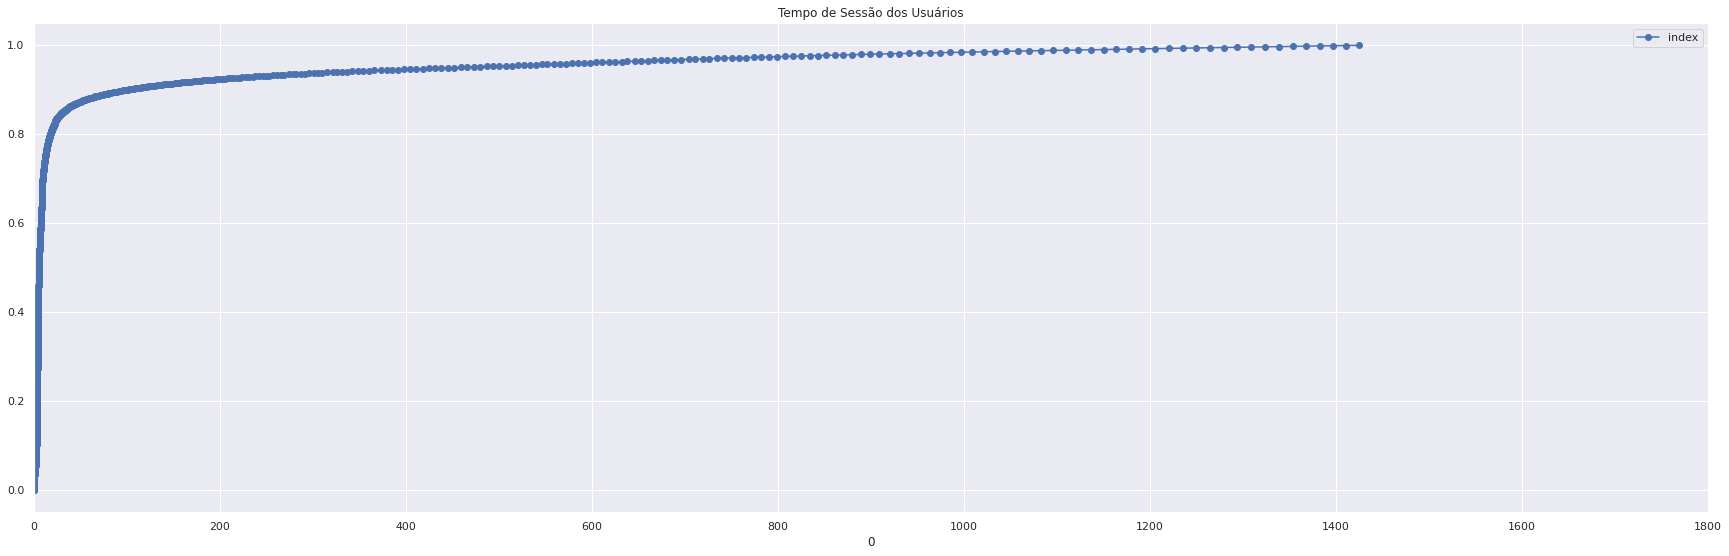

In [18]:
fig.savefig("images/CDF Tempo de Sessão dos Usuários")

90% das vezes uma sessão de um usuário é de 101 minutos

In [ ]:
sessions = sorted_user_history.query("time_diff > 101").index.tolist()
new_users = all_users_history.user.ne(all_users_history.user.shift())[1:]
new_users = new_users.index[new_users == True].tolist()
stop_indexes = sessions + new_users

len(stop_indexes)

522795

In [ ]:
# Loading df with disruption
df_with_disruption = pd.read_csv(Path("../dataset") / "output" / "csv_with_disruption" / "song_info_with_disruption_26638_feat_transfer_learning_gamma_0.1.csv")
df_with_disruption = df_with_disruption.drop(columns=["Unnamed: 0", "index", "mapping_to_fv_index"])
ids_in_dataset = set(df_with_disruption["id"].to_list())

In [ ]:
from tqdm import tqdm
start_index = 0
end_index = 0
user_listening_history_as_clickstream = []

for index, num in tqdm(enumerate(stop_indexes)):
    song_session = sorted_user_history["song"].loc[start_index:num].to_list()
    
    # checking if at least one song in the song session is in the  dataset
    song_in_dataset = False

    for song in song_session:
        if song in ids_in_dataset:
            song_in_dataset = True
            break
    
    if not song_in_dataset:
        continue

    user_listening_history_as_clickstream.append(song_session)
    start_index = num


522795it [01:26, 6066.49it/s]


In [ ]:
len(user_listening_history_as_clickstream)

189178

In [ ]:
# Adding only sessions we have the disruption metric
ids_in_dataset = set(df_with_disruption["id"].to_list())
start_index = 0
end_index = 0
cut_user_listening_history_as_clickstream = []

for song_session in tqdm(user_listening_history_as_clickstream):
    # Check if every song in this session has a disruption metric
    do_not_have_disruption = False

    for song in song_session:
        if song not in ids_in_dataset:
            do_not_have_disruption = True
            break
    
    if do_not_have_disruption:
        continue

    cut_user_listening_history_as_clickstream.append(song_session)

len(cut_user_listening_history_as_clickstream)

100%|██████████| 189178/189178 [00:00<00:00, 887312.18it/s]


11677

In [ ]:
import random

random.shuffle(cut_user_listening_history_as_clickstream)

## Salvando o ngrama dos históricos dos usuários que contém somente as músicas para as quais foram calculadas a disrupção

In [ ]:
import csv
listening_history_file_path = Path("../analyzing_history") / f"only_sessions_with_disruption_{len(cut_user_listening_history_as_clickstream)}.ngram"

with open(listening_history_file_path, "w") as file:
    writer = csv.writer(file)
    writer.writerows(cut_entries)


# Analisando os caminhos gerados

In [3]:
import pathpy as pp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [4]:
listening_history = pp.Paths.read_file(Path("../analyzing_history") / f"only_sessions_with_disruption_{11677}.ngram" \
                                    , frequency=False \
                                    , max_ngram_length=50)
print(listening_history)

2021-09-07 20:25:54 [Severity.INFO]	Reading ngram data ... 
2021-09-07 20:25:54 [Severity.INFO]	finished. Read 11677 paths with maximum length 49
2021-09-07 20:25:54 [Severity.INFO]	Calculating sub path statistics ... 
2021-09-07 20:25:58 [Severity.INFO]	finished.
Total path count: 		11677.0 
[Unique / Sub paths / Total]: 	[11443.0 / 255157.0 / 266834.0]
Nodes:				13241 
Edges:				30277
Max. path length:		49
Avg path length:		3.713025605891924 
Paths of length k = 0		0.0 [ 0.0 / 55034.0 / 55034.0 ]
Paths of length k = 1		4174.0 [ 4000.0 / 39183.0 / 43357.0 ]
Paths of length k = 2		2246.0 [ 2218.0 / 29434.0 / 31680.0 ]
Paths of length k = 3		1372.0 [ 1360.0 / 22805.0 / 24177.0 ]
Paths of length k = 4		923.0 [ 915.0 / 17997.0 / 18920.0 ]
Paths of length k = 5		657.0 [ 653.0 / 14378.0 / 15035.0 ]
Paths of length k = 6		511.0 [ 506.0 / 11562.0 / 12073.0 ]
Paths of length k = 7		396.0 [ 395.0 / 9372.0 / 9768.0 ]
Paths of length k = 8		303.0 [ 303.0 / 7671.0 / 7974.0 ]
Paths of length k = 9	

# Mostrando a capacidade do modelo para representações de alta ordem

In [6]:
max_order = 2
def generate_higher_order_models():
    mog = pp.MultiOrderModel(listening_history, max_order)
    order = mog.estimate_order()
    return mog, order

In [7]:
import pickle

# hon1 = mog.layers[1]
# hon2 = mog.layers[2]

def save(hon1, hon2):
    with open("hon1_with_tags_only_songs_with_disruption.path", "wb") as file:
        pickle.dump(hon1, file)

    with open("hon2_with_tags_only_songs_with_disruption.path", "wb") as file:
        pickle.dump(hon2, file)
        
def apply_tags_to_network():
    disruption_songs_id_set = df_with_disruption.id.values
    songs_list = df_with_disruption.song.values
    for node in tqdm(hon1.nodes):
        if node in disruption_songs_id_set:
            hon1.nodes[node]["song"] = df_with_disruption[df_with_disruption["id"] == node]["song"].iloc[0]
            hon1.nodes[node]["artist"] = df_with_disruption[df_with_disruption["id"] == node]["artist"].iloc[0]
            hon1.nodes[node]["release"] = df_with_disruption[df_with_disruption["id"] == node]["release"].iloc[0]
            hon1.nodes[node]["disruption"] = df_with_disruption[df_with_disruption["id"] == node]["disruption"].iloc[0]
        else:
            hon1.nodes[node]["song"] = None
            hon1.nodes[node]["artist"] = None
            hon1.nodes[node]["release"] = None
            hon1.nodes[node]["disruption"] = None

# Loading Dataframes to merge with the calculated metrics

In [8]:
df_with_disruption = pd.read_csv(Path("../dataset") / "output" / "csv_with_disruption" / "song_info_with_disruption_26638_feat_transfer_learning_gamma_0.1.csv")
df_with_disruption = df_with_disruption.drop(columns=["Unnamed: 0", "index", "mapping_to_fv_index"])

In [9]:
import pathpy as pp
betweenness = pp.algorithms.centralities.betweenness(listening_history)


2021-09-07 20:29:54 [Severity.INFO]	Calculating betweenness in paths ...
2021-09-07 20:29:58 [Severity.INFO]	finished.


In [18]:
closeness = pp.algorithms.centralities.closeness(listening_history)

2021-09-07 20:35:08 [Severity.INFO]	Calculating distance matrix based on empirical paths ...
2021-09-07 20:35:08 [Severity.INFO]	finished.


KeyboardInterrupt: 

In [12]:
import gc
gc.collect()

26504

In [13]:
betweenness_df = pd.DataFrame(betweenness.items(), columns=['id', 'betweenness'])
df_merged_with_betweenness = betweenness_df.merge(df_with_disruption, on="id")

In [14]:
listening_history_net = pp.classes.Network.from_paths(listening_history)
pagerank = pp.algorithms.centralities.pagerank(listening_history_net)

In [15]:
pagerank_ranked = pp.algorithms.centralities.rank_centralities(pagerank)
pagerank_df = pd.DataFrame(pagerank_ranked, columns=['id', 'pagerank'])
df_merged_with_pagerank = pagerank_df.merge(df_merged_with_betweenness, on="id")
df_merged_with_pagerank.head()

,id,pagerank,betweenness,ni,nj,nk,disruption,artist,song,album_name,...,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,NCD8XAG4Q0Nbyr0l,0.000999,198.833333,4.0,0.0,0.0,1.000000,Queen,Bohemian Rhapsody - Remastered 2011,A Night At The Opera (Deluxe Remastered Version),...,7tFiyTwD0nx5a1eklYtX2J,75.0,1975,0.397,0.396,3.0,1.0,0.227,142.913,354320
1,cJCwlS2khI5JxzKJ,0.000939,217.500000,0.0,596.0,274474.0,-0.002167,R.E.M.,Losing My Religion,Out Of Time (25th Anniversary Edition),...,31AOj9sFz2gM0O3hMARRBx,77.0,1991,0.671,0.849,9.0,0.0,0.829,125.613,268427
2,GJBMg2XCb4yuAS4b,0.000854,249.000000,1.0,128.0,16060.0,-0.007845,Pink Floyd,Wish You Were Here,Wish You Were Here,...,6mFkJmJqdDVQ1REhVfGgd1,72.0,1975,0.481,0.262,7.0,1.0,0.375,122.883,334744
3,OxCTebk8s4Ex3yBg,0.000753,212.000000,8.0,567.0,26086.0,-0.020967,Led Zeppelin,Immigrant Song,Led Zeppelin III (Remastered),...,78lgmZwycJ3nzsdgmPPGNx,75.0,1970,0.564,0.932,11.0,1.0,0.619,112.937,146250
4,bwF6WFgG72FvarGJ,0.000738,235.833333,3.0,588.0,92540.0,-0.006281,Pixies,Where Is My Mind?,Surfer Rosa (Remastered),...,6mcxQ1Y3uQRU0IHsvdNLH1,70.0,1988,0.523,0.442,4.0,1.0,0.277,81.083,236973


In [16]:
df_merged_with_pagerank.describe()

,pagerank,betweenness,ni,nj,nk,disruption,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
count,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,13241.000000,1.324100e+04
mean,0.000076,25.849860,3.727286,196.709236,43045.459935,0.040467,39.166453,1986.039196,0.512147,0.653707,5.273846,0.682652,0.524215,121.809603,2.489553e+05
std,0.000070,57.620529,18.239482,308.200977,58480.286636,0.214202,15.267784,11.108999,0.169397,0.234750,3.537083,0.465462,0.255491,28.382512,9.065675e+04
min,0.000015,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1923.000000,0.061700,0.006070,0.000000,0.000000,0.021500,36.710000,3.030700e+04
25%,0.000036,0.000000,0.000000,15.000000,2754.000000,-0.007182,28.000000,1977.000000,0.388000,0.486000,2.000000,0.000000,0.315000,100.110000,1.951870e+05
50%,0.000055,6.000000,0.000000,74.000000,17343.000000,-0.003557,38.000000,1988.000000,0.518000,0.686000,5.000000,1.000000,0.529000,119.866000,2.375600e+05
75%,0.000091,25.000000,2.000000,244.000000,60758.000000,-0.001865,50.000000,1996.000000,0.636000,0.855000,9.000000,1.000000,0.735000,138.908000,2.858930e+05
max,0.000999,1167.500000,846.000000,3544.000000,386389.000000,1.000000,80.000000,2002.000000,0.965000,1.000000,11.000000,1.000000,0.990000,221.947000,1.967400e+06


In [21]:
df_merged_with_pagerank.corr(method="kendall")

,pagerank,betweenness,ni,nj,nk,disruption,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
pagerank,1.000000,0.403750,0.037545,0.044932,0.023563,-0.035728,0.163423,-0.060755,-0.012860,-0.004184,-0.004588,0.011542,0.003544,-0.004169,0.011282
betweenness,0.403750,1.000000,0.058330,0.092871,0.052058,-0.067913,0.113504,-0.120126,-0.060228,0.017030,0.003944,0.024000,-0.012318,0.012406,-0.012695
ni,0.037545,0.058330,1.000000,-0.081307,-0.310993,-0.206103,0.003032,-0.465398,-0.000694,-0.139829,0.000905,0.024780,0.051315,-0.018454,-0.080668
nj,0.044932,0.092871,-0.081307,1.000000,0.697943,-0.282154,0.042929,-0.139317,-0.052303,0.078708,-0.006233,0.047914,0.053363,0.029882,-0.031477
nk,0.023563,0.052058,-0.310993,0.697943,1.000000,0.000908,0.033987,0.067588,-0.032648,0.109416,-0.007709,0.041355,0.038489,0.034971,0.008657
disruption,-0.035728,-0.067913,-0.206103,-0.282154,0.000908,1.000000,-0.011908,0.263010,0.029862,0.011268,0.000176,-0.002767,-0.009885,0.005074,0.041254
popularity,0.163423,0.113504,0.003032,0.042929,0.033987,-0.011908,1.000000,-0.028396,0.159775,-0.033314,-0.007593,0.037000,0.110712,-0.025842,0.026937
release,-0.060755,-0.120126,-0.465398,-0.139317,0.067588,0.263010,-0.028396,1.000000,0.000432,0.174088,0.009653,-0.045552,-0.120095,-0.007557,0.111820
danceability,-0.012860,-0.060228,-0.000694,-0.052303,-0.032648,0.029862,0.159775,0.000432,1.000000,-0.098362,0.008800,-0.026824,0.385826,-0.117120,-0.039531
energy,-0.004184,0.017030,-0.139829,0.078708,0.109416,0.011268,-0.033314,0.174088,-0.098362,1.000000,0.008633,-0.020824,0.102321,0.125433,0.002059


In [36]:
!pip install markovclick

You should consider upgrading via the '/home/giovanni-server/dev/college/TCC/venv/bin/python -m pip install --upgrade pip' command.


In [40]:
pr = pp.algorithms.centralities.pagerank(mog.layers[2])

In [44]:
dict(sorted(pr.items(), key=lambda item: item[1], reverse=True))


{'32m5suoC94ytD8Ed': 0.008649161267246854,
 'vkOg9ZAiUgUT87k6': 0.0032971415184254228,
 'Pf7CTDMAqnLhbcY2': 0.002596178720164225,
 'KKmk2QJLVj2Aqsjg': 0.002559036546985703,
 'YwURIu6eZDCJyuEf': 0.002407641347664748,
 'e8SzjFTY8PQsuSv9': 0.0019202240076126773,
 'YhuXZBiCxjMR4FfQ': 0.001899725159644516,
 '3shrACNQQ5eeQEAO': 0.001653377514508574,
 'EBB7mUheKyVbv6OI': 0.0016367627415860388,
 '7Gsb7yKtAJNCvWez': 0.0015398263626797374,
 'xMkeAOwn6AzEeYGh': 0.0015013045881276674,
 'AYxLbkF55hvueDLM': 0.0014662511892779106,
 'FuVju35v7B0jtKeU': 0.001404768326076708,
 '6YdzDwnoQ34wZoyv': 0.0014026441158352517,
 '8LgQbYbM6Vz2my0y': 0.0013496668841712202,
 'kQYKOpACJ7CUOZVr': 0.0012982503083444384,
 '7PX1VlK5HWCGAoFE': 0.0012926098202888391,
 'cU7wXxFv0vUJTZwr': 0.001251468751852595,
 'a4CorjFKnUQhzVSs': 0.0011610281811444594,
 'TcUb75QrVdYnF7Jo': 0.0011322336522722899,
 'LPDMx981Xn1Hpmrz': 0.001081403628803113,
 '4Ftif9qQReU76eG4': 0.0010704310236343854,
 'Yr0aRxN7lGaLH3xF': 0.001035161270063843

In [ ]:
from markovclick.preprocessing import Sessionise
sessioniser = Sessionise(df, unique_id_col='cookie_id',
			 datetime_col='timestamp', session_timeout=30)
